In [1]:

# ✅ app/agent/router.py
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState

class Router(TypedDict):
    next: Literal["hotel_search_expert", "weather_expert", "place_search_expert", "flight_fares_search_expert", 'FINISH']

class State(MessagesState):
    next: str

In [2]:
# ✅ app/agent/llm_setup.py
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatOpenAI(
    model="gpt-4o", 
    temperature=0.0,
    api_key=os.getenv("OPENAI_API_KEY")
)

In [3]:
# ✅ app/agent/tools.py (Async Refactored)
import os
import math
import httpx
from datetime import datetime, timedelta
from dotenv import load_dotenv
from langchain_core.tools import tool
from typing import Optional

load_dotenv()


async def get_geocode_locationiq(place):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {"key": os.getenv("GEOLOCATION_IQ_API_KEY"), "q": place, "format": "json"}
    async with httpx.AsyncClient() as client:
        res = await client.get(url, params=params)
        data = res.json()
        if data:
            return float(data[0]["lat"]), float(data[0]["lon"])
        else:
            return None


async def location_bbox_search(place):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {"key": os.getenv("GEOLOCATION_IQ_API_KEY"), "q": place, "format": "json"}
    async with httpx.AsyncClient() as client:
        res = await client.get(url, params=params)
        data = res.json()
        if data:
            return data
        else:
            return None

@tool
async def get_places(city: str, query: str = "attractions") -> list:
    """
    Fetches top places (e.g., attractions, restaurants) in a city using the Foursquare Places API
    and returns them as a structured JSON list.

    Parameters:
        city (str): Name of the city (e.g., 'Kolkata')
        query (str): Type of places to search for (e.g., 'attractions', 'museums')

    Returns:
        list: A list of dictionaries, each containing:
            - name: Place name
            - categories: List of category names
            - address: Formatted address
            - latitude: latitude of the address 
            - longitude: longitude of the address 
            - phone: Telephone number if available
            - website: Website URL if available
    """
    
    api_key = os.getenv("FOURSQUARE_API_KEY")
    if not api_key:
        return [{"error": "Missing FOURSQUARE_API_KEY"}]
    url = "https://places-api.foursquare.com/places/search"
    headers = {"accept": "application/json", "X-Places-Api-Version": "2025-06-17", "authorization": api_key}
    params = {"near": city, "query": query, "limit": 10}
    async with httpx.AsyncClient() as client:
        response = await client.get(url, headers=headers, params=params)
        if response.status_code != 200:
            return [{"error": f"Foursquare API error: {response.text}"}]
        results = response.json().get("results", [])
        if not results:
            return [{"message": f"No results found for '{query}' in {city}."}]
        extracted = []
        for place in results:
            address = place['location']['formatted_address']
            lat, lon = await get_geocode_locationiq(address)
            extracted.append({
                "name": place.get("name", "Unknown"),
                "categories": [cat.get("name") for cat in place.get("categories", [])],
                "address": address,
                "latitude": lat,
                "longitude": lon,
                "phone": place.get("tel"),
                "website": place.get("website")
            })
        return extracted


def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate great-circle distance between two points on Earth."""
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    d_phi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)
    a = math.sin(d_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

@tool
async def get_hotels_by_area_and_radius(
    location: str,
    arrival_date: Optional[str] = None,
    departure_date: Optional[str] = None,
    star_rating: str = "3,4,5",
    room_qty: int = 1,
    guest_qty: int = 1,
    children_qty: int = 0,
    children_age: str = "",
    currency: str = "USD",
    order_by: str = "popularity",
    categories_filter: str = "class::1,class::2,class::3",
    language: str = "en-us",
    travel_purpose: str = "leisure",
    offset: int = 0
) -> list:
    """
    Fetch hotel listings within a location, sorted by distance to its center. If no dates are provided, use today's date as `arrival_date` and tomorrow's as `departure_date`.

    Parameters:
        - location (str): The location to search for hotels, such as an area name, locality, or city (e.g., "Koramangala, Bangalore").
        - star_rating (str): Comma-separated star classes to filter, e.g., "3,4,5"
        - arrival_date (str): Check-in date (YYYY-MM-DD)
        - departure_date (str): Check-out date (YYYY-MM-DD)
        - room_qty (int): Number of rooms
        - guest_qty (int): Number of adults
        - children_qty (int): Number of children
        - children_age (str): Comma-separated list of children ages
        - currency (str): Price currency (e.g., USD, INR)
        - order_by (str): API sort preference (not used post-filter)
        - categories_filter (str): Used internally, overridden by star_rating
        - language (str): Response language
        - travel_purpose (str): "leisure" or "business"
        - offset (int): Pagination offset

    Returns:
        - list of hotel dicts sorted by ascending distance from bbox center.
    """
    
    res = await location_bbox_search(location)
    bbox = ",".join(res[0]['boundingbox'])
    
    
    today = datetime.today()
    
    if not arrival_date:
        arrival_date = today.strftime("%Y-%m-%d")
        
    if not departure_date:
        departure_date = (today + timedelta(days=1)).strftime("%Y-%m-%d")

    categories_filter = ",".join([f"class::{s.strip()}" for s in star_rating.split(",")])

    try:
        min_lat, max_lat, min_lng, max_lng = map(float, bbox.split(","))
        center_lat = (min_lat + max_lat) / 2
        center_lng = (min_lng + max_lng) / 2
    except Exception as e:
        return [{"error": f"Invalid bbox format: {e}"}]

    url = "https://apidojo-booking-v1.p.rapidapi.com/properties/list-by-map"
    querystring = {
        "room_qty": str(room_qty),
        "guest_qty": str(guest_qty),
        "bbox": bbox,
        "search_id": "none",
        "children_age": children_age,
        "price_filter_currencycode": currency,
        "categories_filter": categories_filter,
        "languagecode": language,
        "travel_purpose": travel_purpose,
        "children_qty": str(children_qty),
        "order_by": order_by,
        "offset": str(offset),
        "arrival_date": arrival_date,
        "departure_date": departure_date
    }
    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY_HOTELS"),
        "x-rapidapi-host": "apidojo-booking-v1.p.rapidapi.com"
    }

    async with httpx.AsyncClient() as client:
        response = await client.get(url, headers=headers, params=querystring)
        if response.status_code != 200:
            return [{"error": response.text}]

        results = response.json().get("result", [])
        hotels = []

        for item in results:
            if not item.get("class"):
                continue
            lat = item.get("latitude")
            lng = item.get("longitude")
            if lat is None or lng is None:
                continue

            distance_km = haversine_distance(center_lat, center_lng, lat, lng)
            hotels.append({
                "name": item.get("hotel_name"),
                "star_rating": item.get("class"),
                "review_score": item.get("review_score"),
                "review_word": item.get("review_score_word"),
                "review_count": item.get("review_nr"),
                "address": item.get("address"),
                "city": item.get("city"),
                "district": item.get("district"),
                "latitude": lat,
                "longitude": lng,
                "price_per_night": item.get("min_total_price") or item.get("price_breakdown", {}).get("all_inclusive_price"),
                "currency": item.get("currencycode", currency),
                "image": item.get("main_photo_url"),
                "booking_url": item.get("url"),
                "is_free_cancellable": item.get("is_free_cancellable"),
                "is_mobile_deal": item.get("is_mobile_deal"),
                "checkin_from": item.get("checkin", {}).get("from"),
                "checkout_until": item.get("checkout", {}).get("until"),
                "arrival_date": arrival_date,
                "departure_date": departure_date,
                "distance_km": round(distance_km, 2)
            })

        hotels.sort(key=lambda h: h["distance_km"])
        return hotels


@tool
async def get_weather(city: str) -> dict:
    """Get detailed current weather data for a city as a dictionary."""
    
    api_key = os.getenv("OPENWEATHER_API_KEY")
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    async with httpx.AsyncClient() as client:
        response = await client.get(url)
        if response.status_code != 200:
            return {"error": f"Failed to get weather: {response.text}"}
        data = response.json()
        lat, lon = await get_geocode_locationiq(city)
        return {
            "city": data.get("name"),
            "country": data.get("sys", {}).get("country"),
            "description": data.get("weather", [{}])[0].get("description"),
            "temperature_celsius": data.get("main", {}).get("temp"),
            "feels_like_celsius": data.get("main", {}).get("feels_like"),
            "temp_min": data.get("main", {}).get("temp_min"),
            "temp_max": data.get("main", {}).get("temp_max"),
            "humidity": data.get("main", {}).get("humidity"),
            "pressure": data.get("main", {}).get("pressure"),
            "wind_speed_mps": data.get("wind", {}).get("speed"),
            "wind_deg": data.get("wind", {}).get("deg"),
            "visibility_m": data.get("visibility"),
            "cloud_coverage_percent": data.get("clouds", {}).get("all"),
            "sunrise_utc": data.get("sys", {}).get("sunrise"),
            "sunset_utc": data.get("sys", {}).get("sunset"),
            "icon": data.get("weather", [{}])[0].get("icon"),
            "latitude": lat,
            "longitude": lon
        }


@tool
async def get_flight_fares(from_code: str, to_code: str, date: str, adult: int = 1, type_: str = "economy") -> list:
    """
    Fetches flight fare data using the Flight Fare Search API on RapidAPI.

    Args:
        from_code (str): IATA code of departure airport (e.g., 'BLR')
        to_code (str): IATA code of arrival airport (e.g., 'CCU')
        date (str): Travel date in YYYY-MM-DD
        adult (int): Number of adult passengers (default: 1)
        type_ (str): Cabin class (default: 'economy')

    Returns:
        list: List of flights with key details: timing, pricing, stops, countries, and cabin info.
    """
    
    url = "https://flight-fare-search.p.rapidapi.com/v2/flights"
    querystring = {"from": from_code, "to": to_code, "date": date, "adult": str(adult), "type": type_, "currency": "USD"}
    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY_FLIGHTS"),
        "x-rapidapi-host": "flight-fare-search.p.rapidapi.com"
    }
    async with httpx.AsyncClient() as client:
        response = await client.get(url, headers=headers, params=querystring)
        try:
            raw = response.json()
            flights = raw.get("results", [])
            if not isinstance(flights, list) or not flights:
                return [{"message": "No flights found."}]
            results = []
            for f in flights:
                stop_summary = f.get("stopSummary", {})
                stop_info = [{"intermediate_airport": val.get("airport", "Unknown"), "stop_duration_minutes": val.get("stopDuration")}
                                for key, val in stop_summary.items() if key != "connectingTime" and isinstance(val, dict)]
                results.append({
                    "flight_code": f.get("flight_code"),
                    "airline": f.get("flight_name"),
                    "cabin_type": f.get("cabinType", "Unknown"),
                    "stops": f.get("stops", "Unknown"),
                    "departure_city": f.get("departureAirport", {}).get("city"),
                    "departure_country": f.get("departureAirport", {}).get("country", {}).get("label"),
                    "departure_time": f.get("departureAirport", {}).get("time"),
                    "arrival_city": f.get("arrivalAirport", {}).get("city"),
                    "arrival_country": f.get("arrivalAirport", {}).get("country", {}).get("label"),
                    "arrival_time": f.get("arrivalAirport", {}).get("time"),
                    "duration": f.get("duration", {}).get("text"),
                    "price": f.get("totals", {}).get("total"),
                    "currency": f.get("totals", {}).get("currency"),
                    "intermediate_stops": stop_info if stop_info else None
                })
            return results
        except Exception as e:
            return [{"error": str(e)}]

In [4]:
# app/agent/agent.py

from typing import Literal
from langgraph.graph import END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
# from app.agent.tools import *
# from app.agent.llm_setup import llm
# from app.agent.router import Router, State

async def supervisor(state: State) -> Command[Literal["hotel_search_expert", "weather_expert", "place_search_expert", "flight_fares_search_expert", "__end__"]]:
    """
    The supervisor routes tasks to the appropriate expert based on the user message context.
    It uses an LLM with structured output to decide which agent to call next.
    """
    system_prompt = f"""
    You are a Supervisor Agent coordinating a travel assistant system with the following expert agents:
    {', '.join([
        'hotel_search_expert',
        'weather_expert',
        'place_search_expert',
        'flight_fares_search_expert'
    ])}

    Each agent performs a specific task:
    - hotel_search_expert: Finds real-time hotels using a bounding box, travel dates, and optional filters (e.g., star rating)
    - weather_expert: Returns current weather for a given city
    - place_search_expert: Suggests attractions, restaurants, and cultural spots near a location
    - flight_fares_search_expert: Finds flights and fares between two IATA codes on a specific date

    Your role:
    - Read the latest user query and conversation context
    - Decide which agent to invoke next
    - Handle dependencies (e.g., get bbox before hotel search)
    - Reply FINISH only after the user's request is fully satisfied

    Always include `latitude` and `longitude` for any place-related query (e.g., city, hotel, restaurant, attraction) in the final output — either in the main content or structured HTML.

    Response format:
    Return ONLY one of the following at a time:
    - The name of the agent to call next (e.g., hotel_search_expert)
    - A short explanation of why that agent is needed
    - Input hints or parameters for the agent
    - The word FINISH if all steps are complete

    - For flight searches between cities with a date, directly call flight_fares_search_expert

    - Always decompose multi-part goals (e.g., hotels + weather + flights) into sequential steps

    - Do NOT hallucinate inputs or output — only use what is extracted or known
    - Never assign tasks outside an expert’s scope

    Once the user's goal is complete and no other agent needs to be invoked, return FINISH.

    User Request:
    """
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    llm_with_structure_output = llm.with_structured_output(Router)
    response = await llm_with_structure_output.ainvoke(messages)
    
    goto = response["next"]
    
    if goto == "FINISH":
        goto = END
        
    return Command(goto=goto, update={"next": goto})

async def hotel_search_agent(state: State) -> Command[Literal["supervisor"]]:
    """
    The hotel expert uses the hotel-related tools to find hotels based on location, star rating, and dates.
    """
    agent = create_react_agent(
        llm, 
        tools=[get_hotels_by_area_and_radius], 
        prompt="""
            You are a hotel search expert. Geocode the location first if bbox is missing. 
            Then use the hotel search tool to find top results. For each hotel, return the following fields in HTML format:

            - name
            - star_rating
            - review_score
            - review_word
            - review_count
            - address
            - city
            - district
            - latitude
            - longitude
            - price_per_night
            - currency
            - image
            - booking_url
            - is_free_cancellable
            - is_mobile_deal
            - checkin_from
            - checkout_until
            - arrival_date
            - departure_date
            - distance_km
            
            `latitude` and `longitude` must always be included.
            Do not return bbox, display_name, or type in the final output. Just output a clean HTML <ul> list showing all above fields.
        """
    )
    
    result = await agent.ainvoke(state)
    
    return Command(update={"messages": [HumanMessage(content=result["messages"][-1].content, name="hotel_search_expert")]}, goto="supervisor")


async def weather_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[get_weather],
        prompt="""
            You are a weather expert. Use the weather tool to fetch real-time weather for the user's city.

            Return the result in clean HTML format using <ul>/<li> or <div>. Include:

            - City and Country
            - Description (e.g., clear sky, light rain)
            - Temperature (actual, feels like, min, max)
            - Humidity, Pressure
            - Wind speed and direction
            - Visibility (in meters), Cloud Coverage (%)
            - Sunrise and Sunset in UTC
            - Latitude and Longitude (always include)
            - Optional: weather icon <img> if available
            
            `latitude` and `longitude` must always be included.
            Do not use JSON or plain text. Only output valid, well-structured HTML.
            """


)
        
    result = await agent.ainvoke(state)
    
    return Command(update={"messages": [HumanMessage(content=result["messages"][-1].content, name="weather_expert")]}, goto="supervisor")

async def place_search_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
            llm,
            tools=[get_places],
            prompt="""
                You are an expert in finding attractions, restaurants, and cultural places.

                Use the get_places tool to return the top 5 places.

                For each result, include:
                - Name
                - Category (e.g., museum, restaurant)
                - Address
                - Latitude and Longitude (always include)
                - Phone (if available)
                - Website (as a clickable link)
                
                `latitude` and `longitude` must always be included.
                Return the output in clean HTML format using <ul>/<li> or <div>. No JSON or plain text. Keep it structured and readable.
        """


    )
    result = await agent.ainvoke(state)
    return Command(update={"messages": [HumanMessage(content=result["messages"][-1].content, name="place_search_expert")]}, goto="supervisor")

async def flight_fares_search_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
            llm,
            tools=[get_flight_fares],
            prompt="""
                You are a flight search expert. Use the flight API to return flight fares and details.

                For each result, include:
                - From and To airport codes
                - Departure and Arrival time
                - Airline and number of Stops
                - Fare with currency

                Respond in HTML format using <ul>/<li> or <div>. Avoid JSON or plain text.
                """


    )
    result = await agent.ainvoke(state)
    return Command(update={"messages": [HumanMessage(content=result["messages"][-1].content, name="flight_fares_search_expert")]}, goto="supervisor")

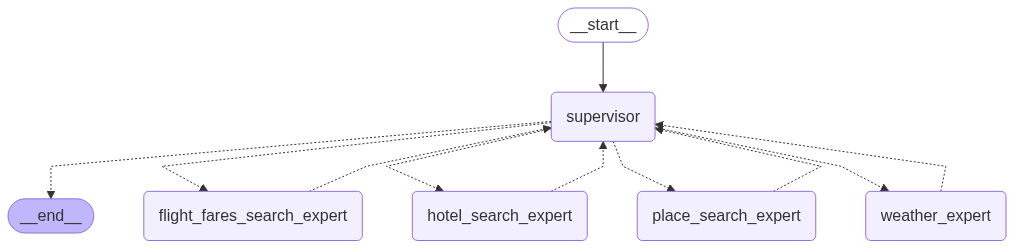

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
# from app.agent.router import State
# from app.agent.agent import *

graph = StateGraph(State)

graph.add_node("supervisor", supervisor)
graph.add_node("hotel_search_expert", hotel_search_agent)
graph.add_node("weather_expert", weather_agent)
graph.add_node("place_search_expert", place_search_agent)
graph.add_node("flight_fares_search_expert", flight_fares_search_agent)

graph.add_edge(START, "supervisor")
graph.add_edge("hotel_search_expert", "supervisor")
graph.add_edge("weather_expert", "supervisor")
graph.add_edge("place_search_expert", "supervisor")
graph.add_edge("flight_fares_search_expert", "supervisor")
graph.add_edge("supervisor", END)

memory = MemorySaver()
app = graph.compile()
app

In [6]:
# import asyncio

# async def test_async_multiagent():
#     from app.agent.graph import app
#     print("Testing the multi-agent system...")
#     print("=" * 50)

#     stream = app.astream(
#         {
#             "messages": [
#                 ("user", """
#                 I’m planning a short leisure trip to South Goa. Please suggest some 3-star or 4-star hotels in that area with 
#                 free cancellation options if available. I’ll be traveling as an adult, with check-in on July 19, 2025, and check-out on July 22, 2025.
#                 """)
#             ]
#         },
#         stream_mode="values"
#     )

#     res = []
#     async for event in stream:
#         event["messages"][-1].pretty_print()
#         content = event["messages"][-1].content
#         if content:
#             res.append(content)

#     return res

# # Run the test (only for local execution, not Runpod)
# if __name__ == "__main__":
#     asyncio.run(test_async_multiagent())

In [7]:
# ## app/main.py

# import os
# os.environ.pop("SSL_CERT_FILE", None)

# from fastapi import FastAPI
# from pydantic import BaseModel
# from langchain_core.messages import HumanMessage
# from app.agent.graph import app as travel_graph
# from fastapi.middleware.cors import CORSMiddleware
# from fastapi.staticfiles import StaticFiles
# from fastapi.responses import FileResponse

# app = FastAPI()

# app.add_middleware(
#     CORSMiddleware,
#     allow_origins=["*"],
#     allow_credentials=True,
#     allow_methods=["*"],
#     allow_headers=["*"],
# )

# app.mount("/static", StaticFiles(directory="frontend"), name="static")

# class TravelQuery(BaseModel):
#     message: str

# @app.post("/plan-trip")
# async def plan_trip(query: TravelQuery):
#     try:
#         stream = travel_graph.astream(
#             {"messages": [HumanMessage(content=query.message)]},
#             config={"configurable": {"thread_id": "user-thread"}},
#             stream_mode="values"
#         )
#         result = []
#         async for event in stream:
#             content = event["messages"][-1].content
#             if content:
#                 result.append(content)
#         return {"response": result[-1] if result else "No response from model."}
#     except Exception as e:
#         print("❌ Error in /plan-trip:", str(e))
#         return {"response": "⚠️ Sorry, something went wrong on the server."}

# @app.get("/")
# def serve_ui():
#     return FileResponse("frontend/index.html")
